<a href="https://colab.research.google.com/github/jatinsingh234/PeleeNet-SSD/blob/main/peele2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%ls
%cd drive
%cd MyDrive/
%cd Colab\ Notebooks
%cd pelee_keras/
%cd experiments/
#if training on coco dataset, uncomment utils/data_gen.py line 676

drive/  sample_data/
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/pelee_keras
/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments


#Train

In [ ]:
import os
import re
import sys
sys.path.append('../')
import tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from models.pelee import pelee
from losses.keras_ssd_loss import SSDLoss
from utils.object_detection_2d_data_generator import DataGenerator
from utils.object_detection_2d_geometric_ops import Resize
from utils.object_detection_2d_photometric_ops import ConvertTo3Channels
from utils.data_augmentation_chain_original_ssd import SSDDataAugmentation
from utils.coco import get_coco_category_maps
from utils.ssd_input_encoder import SSDInputEncoder
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler

# model config
batch_size = 32
image_size = (300, 300, 3)
n_classes = 80
mode = 'training'
l2_regularization = 0.0005
###################### experiment with scales
min_scale = 0.05
max_scale = 0.8
scales = None
aspect_ratios_global = None
aspect_ratios_per_layer = [[1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0]]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
coords = 'centroids'
normalize_coords = True
subtract_mean = [123, 117, 104]
divide_by_stddev = 128
swap_channels = None
confidence_thresh = 0.01
iou_threshold = 0.45
top_k = 200
nms_max_output_size = 400
return_predictor_sizes = False

K.clear_session()

# file paths
# train_images_dir = '/media/shishuai/DATA1/Documents/Datasets/COCO2017/train2017/'
# train_annotations_filename = '/media/shishuai/DATA1/Documents/Datasets/COCO2017/annotations/instances_train2017.json'
# val_images_dir = '/media/shishuai/DATA1/Documents/Datasets/COCO2017/val2017/'
# val_annotations_filename = '/media/shishuai/DATA1/Documents/Datasets/COCO2017/annotations/instances_val2017.json'
# log_dir = '/media/shishuai/DATA1/Documents/pelee_keras_logs/0415'

train_images_dir = '../dataset/merged'
train_annotations_filename = './Merge_COCO_FILES/out.json'
val_images_dir = '../dataset/new-training/train'
val_annotations_filename = '../dataset/new-training/train.json'
log_dir = '../Pelee_keras_logs4-10k'
# learning rate schedule
def lr_schedule(epoch):
    if epoch < 25:
        return 0.00001
    elif epoch < 50:
        return 0.00001
    else:
        return 0.000001


# set trainable layers
def set_trainable(layer_regex, keras_model=None, indent=0, verbose=1):
    # In multi-GPU training, we wrap the model. Get layers
    # of the inner model because they have the weights.
    layers = keras_model.inner_model.layers if hasattr(keras_model, "inner_model") \
        else keras_model.layers

    for layer in layers:
        # Is the layer a model?
        if layer.__class__.__name__ == 'Model':
            print("In model: ", layer.name)
            set_trainable(
                layer_regex, keras_model=layer)
            continue

        if not layer.weights:
            continue
        # Is it trainable?
        trainable = bool(re.fullmatch(layer_regex, layer.name))
        # Update layer. If layer is a container, update inner layer.
        if layer.__class__.__name__ == 'TimeDistributed':
            layer.layer.trainable = trainable
        else:
            layer.trainable = trainable
        # Print trainable layer names
        if trainable and verbose > 0:
            print("{}{:20}   ({})".format(" " * indent, layer.name, layer.__class__.__name__))


# build model

model = pelee(image_size, n_classes, mode, l2_regularization, min_scale, max_scale, scales,
                         aspect_ratios_global, aspect_ratios_per_layer, two_boxes_for_ar1, steps,
                         offsets, clip_boxes, variances, coords, normalize_coords, subtract_mean,
                         divide_by_stddev, swap_channels, confidence_thresh, iou_threshold, top_k,
                         nms_max_output_size, return_predictor_sizes)

# load weights
weights_path = '../Pelee_keras_logs4-10k/pelee_coco_5thRun_04_loss-4.2859_val_loss-3.9978.h5'

model.load_weights(weights_path, by_name=True)

# compile the model
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
# set_trainable(r"(ssd\_.*)", model)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss, metrics=["acc"])

#print(model.summary())

# load data
train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

train_dataset.parse_json(images_dirs=[train_images_dir], annotations_filenames=[train_annotations_filename],
                         ground_truth_available=True, include_classes='all', ret=False)
val_dataset.parse_json(images_dirs=[val_images_dir], annotations_filenames=[val_annotations_filename],
                       ground_truth_available=True, include_classes='all', ret=False)

# We need the `classes_to_cats` dictionary. Read the documentation of this function to understand why.
cats_to_classes, classes_to_cats, cats_to_names, classes_to_names = get_coco_category_maps(train_annotations_filename)

# set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=image_size[0],
                                            img_width=image_size[1],
                                            background=subtract_mean)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=image_size[0], width=image_size[1])

# instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('ssd_cls1conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls2conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls3conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls4conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls5conv2_bn').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=image_size[0],
                                    img_width=image_size[1],
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios_per_layer,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)

# create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

callbacks = [LearningRateScheduler(schedule=lr_schedule, verbose=1),
             TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=False),
             ModelCheckpoint(
                 os.path.join(log_dir, "pelee_coco_7thRun_{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5"),
                 monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)]

history = model.fit(train_generator, epochs=50, steps_per_epoch=100,
                    callbacks=callbacks, validation_data=val_generator,
                    validation_steps=100, initial_epoch=0)


xxxxxxxxxxxxxxxxxxxxxxxx
(None, 9, 9, 512)
(None, 9, 9, 704)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Processing 'train.json': 100%|██████████| 144/144 [00:00<00:00, 54708.31it/s]
Number of images in the training dataset:	 10000
Number of images in the validation dataset:	   144


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00001: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 4.2736 - acc: 0.4296
Epoch 00001: val_loss improved from inf to 3.99758, saving model to ../Pelee_keras_logs4-10k/pelee_coco_7thRun_01_loss-4.2736_val_loss-3.9976.h5
100/100 [==============================] - 750s 7s/step - loss: 4.2736 - acc: 0.4296 - val_loss: 3.9976 - val_acc: 0.4103 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler setting learning rate to 1e-05.
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 4.2553 - acc: 0.4295
Epoch 00002: val_loss did not improve from 3.99758
100/100 [==============================] - 704s 7s/step - loss: 4.2553 - acc: 0.4295 - val_loss: 3.9985 - val_acc: 0.4124 - lr: 1.0000e-05

Epoch 00003: LearningRateScheduler setting learning rate to 1e-05.
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 4.1296 - acc: 0.4285
Epoch 00003: val_loss did not improve from 3.9975

#Evaluator

In [ ]:
"""
An evaluator to compute the Pascal VOC-style mean average precision (both the pre-2010
and post-2010 algorithm versions) of a given Keras SSD model on a given dataset.
Copyright (C) 2018 Pierluigi Ferrari
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
   http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

from __future__ import division
import numpy as np
from math import ceil
from tqdm import trange
import sys
import warnings
sys.path.append('../')
from utils.object_detection_2d_data_generator import DataGenerator
from utils.object_detection_2d_geometric_ops import Resize
from utils.object_detection_2d_patch_sampling_ops import RandomPadFixedAR
from utils.object_detection_2d_photometric_ops import ConvertTo3Channels
from utils.ssd_output_decoder import decode_detections
from utils.object_detection_2d_misc import apply_inverse_transforms

from utils.bounding_box import iou


class Evaluator:
    """
    Computes the mean average precision of the given Keras SSD model on the given dataset.
    Can compute the Pascal-VOC-style average precision in both the pre-2010 (k-point sampling)
    and post-2010 (integration) algorithm versions.
    Optionally also returns the average precisions, precisions, and recalls.
    The algorithm is identical to the official Pascal VOC pre-2010 detection evaluation algorithm
    in its default settings, but can be cusomized in a number of ways.
    """

    def __init__(self,
                 model,
                 n_classes,
                 data_generator,
                 model_mode='inference',
                 pred_format={'class_id': 0, 'conf': 1, 'xmin': 2, 'ymin': 3, 'xmax': 4, 'ymax': 5},
                 gt_format={'class_id': 0, 'xmin': 1, 'ymin': 2, 'xmax': 3, 'ymax': 4}):
        """
        Arguments:
            model (Keras model): A Keras SSD model object.
            n_classes (int): The number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO.
            data_generator (DataGenerator): A `DataGenerator` object with the evaluation dataset.
            model_mode (str, optional): The mode in which the model was created, i.e. 'training', 'inference' or
                'inference_fast'. This is needed in order to know whether the model output is already decoded or
                still needs to be decoded. Refer to the model documentation for the meaning of the individual modes.
            pred_format (dict, optional): A dictionary that defines which index in the last axis of the model's
                decoded predictions contains which bounding box coordinate. The dictionary must map the keywords
                'class_id', 'conf' (for the confidence), 'xmin', 'ymin', 'xmax', and 'ymax' to their
                respective indices within last axis.
            gt_format (list, optional): A dictionary that defines which index of a ground truth bounding box
                contains which of the five items class ID, xmin, ymin, xmax, ymax. The expected strings are
                'xmin', 'ymin', 'xmax', 'ymax', 'class_id'.
        """

        if not isinstance(data_generator, DataGenerator):
            warnings.warn("`data_generator` is not a `DataGenerator` object, which will cause undefined behavior.")

        self.model = model
        self.data_generator = data_generator
        self.n_classes = n_classes
        self.model_mode = model_mode
        self.pred_format = pred_format
        self.gt_format = gt_format

        # The following lists all contain per-class data, i.e. all list have the length `n_classes + 1`,
        # where one element is for the background class, i.e. that element is just a dummy entry.
        self.prediction_results = None
        self.num_gt_per_class = None
        self.true_positives = None
        self.false_positives = None
        self.cumulative_true_positives = None
        self.cumulative_false_positives = None
        # "Cumulative" means that the i-th element in each list represents the precision for
        # the first i highest condidence predictions for that class.
        self.cumulative_precisions = None
        # "Cumulative" means that the i-th element in each list represents the recall for
        # the first i highest condidence predictions for that class.
        self.cumulative_recalls = None
        self.average_precisions = None
        self.mean_average_precision = None

    def __call__(self,
                 img_height,
                 img_width,
                 batch_size,
                 data_generator_mode='resize',
                 round_confidences=False,
                 matching_iou_threshold=0.5,
                 border_pixels='include',
                 sorting_algorithm='quicksort',
                 average_precision_mode='sample',
                 num_recall_points=11,
                 ignore_neutral_boxes=True,
                 return_precisions=False,
                 return_recalls=False,
                 return_average_precisions=False,
                 verbose=True,
                 decoding_confidence_thresh=0.45,
                 decoding_iou_threshold=0.45,
                 decoding_top_k=200,
                 decoding_pred_coords='centroids',
                 decoding_normalize_coords=True):
        """
        Computes the mean average precision of the given Keras SSD model on the given dataset.
        Optionally also returns the averages precisions, precisions, and recalls.
        All the individual steps of the overall evaluation algorithm can also be called separately
        (check out the other methods of this class), but this runs the overall algorithm all at once.
        Arguments:
            img_height (int): The input image height for the model.
            img_width (int): The input image width for the model.
            batch_size (int): The batch size for the evaluation.
            data_generator_mode (str, optional): Either of 'resize' and 'pad'. If 'resize', the input images will
                be resized (i.e. warped) to `(img_height, img_width)`. This mode does not preserve the aspect ratios
                of the images. If 'pad', the input images will be first padded so that they have the aspect ratio
                defined by `img_height` and `img_width` and then resized to `(img_height, img_width)`.
                This mode preserves the aspect ratios of the images.
            round_confidences (int, optional): `False` or an integer that is the number of decimals that the prediction
                confidences will be rounded to. If `False`, the confidences will not be rounded.
            matching_iou_threshold (float, optional): A prediction will be considered a true positive if it has a
                Jaccard overlap of at least `matching_iou_threshold` with any ground truth bounding box of the same
                class.
            border_pixels (str, optional): How to treat the border pixels of the bounding boxes.
                Can be 'include', 'exclude', or 'half'. If 'include', the border pixels belong
                to the boxes. If 'exclude', the border pixels do not belong to the boxes.
                If 'half', then one of each of the two horizontal and vertical borders belong
                to the boxex, but not the other.
            sorting_algorithm (str, optional): Which sorting algorithm the matching algorithm should use.
                This argument accepts any valid sorting algorithm for Numpy's `argsort()` function.
                You will usually want to choose between 'quicksort' (fastest and most memory efficient, but not stable)
                and 'mergesort' (slight slower and less memory efficient, but stable). The official Matlab evaluation
                algorithm uses a stable sorting algorithm, so this algorithm is only guaranteed to behave identically
                if you choose 'mergesort' as the sorting algorithm, but it will almost always behave identically
                even if you choose 'quicksort' (but no guarantees).
            average_precision_mode (str, optional): Can be either 'sample' or 'integrate'. In the case of 'sample',
                the average precision will be computed according to the Pascal VOC formula that was used up until
                VOC 2009, where the precision will be sampled for `num_recall_points` recall values. In the case of
                'integrate', the average precision will be computed according to the Pascal VOC formula that was used
                from VOC 2010 onward, where the average precision will be computed by numerically integrating over the
                whole preciscion-recall curve instead of sampling individual points from it.
                'integrate' mode is basically just the limit case of 'sample' mode as the number of sample
                points increases.
            num_recall_points (int, optional): The number of points to sample from the precision-recall-curve
                to compute the average precisions. In other words, this is the number of equidistant recall values
                for which the resulting precision will be computed. 11 points is the value used in the official
                Pascal VOC 2007 detection evaluation algorithm.
            ignore_neutral_boxes (bool, optional): In case the data generator provides annotations indicating
                whether a ground truth bounding box is supposed to either count or be neutral for the evaluation,
                this argument decides what to do with these annotations. If `False`, even boxes that are annotated
                as neutral will be counted into the evaluation. If `True`, neutral boxes will be ignored for the
                evaluation. An example for evaluation-neutrality are the ground truth boxes annotated as "difficult"
                in the Pascal VOC datasets, which are usually treated as neutral for the evaluation.
            return_precisions (bool, optional): If `True`, returns a nested list containing the cumulative precisions
                for each class.
            return_recalls (bool, optional): If `True`, returns a nested list containing the cumulative
                recalls for each class.
            return_average_precisions (bool, optional): If `True`, returns a list containing the average
                precision for each class.
            verbose (bool, optional): If `True`, will print out the progress during runtime.
            decoding_confidence_thresh (float, optional): Only relevant if the model is in 'training' mode.
                A float in [0,1), the minimum classification confidence in a specific positive class in order
                to be considered for the non-maximum suppression stage for the respective class.
                A lower value will result in a larger part of the selection process being done by the non-maximum
                suppression stage, while a larger value will result in a larger part of the selection process
                happening in the confidence thresholding stage.
            decoding_iou_threshold (float, optional): Only relevant if the model is in 'training' mode.
                A float in [0,1]. All boxes with a Jaccard similarity of greater than `iou_threshold` with
                a locally maximal box will be removed from the set of predictions for a given class,
                where 'maximal' refers to the box score.
            decoding_top_k (int, optional): Only relevant if the model is in 'training' mode. The number
                of highest scoring predictions to be kept for each batch item after the non-maximum suppression
                stage.
            decoding_input_coords (str, optional): Only relevant if the model is in 'training' mode.
                The box coordinate format that the model outputs. Can be either 'centroids' for the format
                `(cx, cy, w, h)` (box center coordinates, width, and height), 'minmax' for the format
                `(xmin, xmax, ymin, ymax)`, or 'corners' for the format `(xmin, ymin, xmax, ymax)`.
            decoding_normalize_coords (bool, optional): Only relevant if the model is in 'training' mode.
                Set to `True` if the model outputs relative coordinates. Do not set this to `True`
                if the model already outputs absolute coordinates, as that would result in incorrect coordinates.
        Returns:
            A float, the mean average precision, plus any optional returns specified in the arguments.
        """

        #############################################################################################
        # Predict on the entire dataset.
        #############################################################################################

        self.predict_on_dataset(img_height=img_height,
                                img_width=img_width,
                                batch_size=batch_size,
                                data_generator_mode=data_generator_mode,
                                decoding_confidence_thresh=decoding_confidence_thresh,
                                decoding_iou_threshold=decoding_iou_threshold,
                                decoding_top_k=decoding_top_k,
                                decoding_pred_coords=decoding_pred_coords,
                                decoding_normalize_coords=decoding_normalize_coords,
                                decoding_border_pixels=border_pixels,
                                round_confidences=round_confidences,
                                verbose=verbose,
                                ret=False)

        #############################################################################################
        # Get the total number of ground truth boxes for each class.
        #############################################################################################

        self.get_num_gt_per_class(ignore_neutral_boxes=ignore_neutral_boxes,
                                  verbose=False,
                                  ret=False)

        #############################################################################################
        # Match predictions to ground truth boxes for all classes.
        #############################################################################################

        self.match_predictions(ignore_neutral_boxes=ignore_neutral_boxes,
                               matching_iou_threshold=matching_iou_threshold,
                               border_pixels=border_pixels,
                               sorting_algorithm=sorting_algorithm,
                               verbose=verbose,
                               ret=False)

        #############################################################################################
        # Compute the cumulative precision and recall for all classes.
        #############################################################################################

        self.compute_precision_recall(verbose=verbose, ret=False)

        #############################################################################################
        # Compute the average precision for this class.
        #############################################################################################

        self.compute_average_precisions(mode=average_precision_mode,
                                        num_recall_points=num_recall_points,
                                        verbose=verbose,
                                        ret=False)

        #############################################################################################
        # Compute the mean average precision.
        #############################################################################################

        mean_average_precision = self.compute_mean_average_precision(ret=True)

        #############################################################################################

        # Compile the returns.
        if return_precisions or return_recalls or return_average_precisions:
            ret = [mean_average_precision]
            if return_average_precisions:
                ret.append(self.average_precisions)
            if return_precisions:
                ret.append(self.cumulative_precisions)
            if return_recalls:
                ret.append(self.cumulative_recalls)
            return ret
        else:
            return mean_average_precision

    def predict_on_dataset(self,
                           img_height,
                           img_width,
                           batch_size,
                           data_generator_mode='resize',
                           decoding_confidence_thresh=0.4,
                           decoding_iou_threshold=0.45,
                           decoding_top_k=200,
                           decoding_pred_coords='centroids',
                           decoding_normalize_coords=True,
                           decoding_border_pixels='include',
                           round_confidences=False,
                           verbose=True,
                           ret=False):
        """
        Runs predictions for the given model over the entire dataset given by `data_generator`.
        Arguments:
            img_height (int): The input image height for the model.
            img_width (int): The input image width for the model.
            batch_size (int): The batch size for the evaluation.
            data_generator_mode (str, optional): Either of 'resize' and 'pad'. If 'resize', the input images will
                be resized (i.e. warped) to `(img_height, img_width)`. This mode does not preserve the aspect ratios
                of the images. If 'pad', the input images will be first padded so that they have the aspect ratio
                defined by `img_height` and `img_width` and then resized to `(img_height, img_width)`.
                This mode preserves the aspect ratios of the images.
            decoding_confidence_thresh (float, optional): Only relevant if the model is in 'training' mode.
                A float in [0,1), the minimum classification confidence in a specific positive class in order
                to be considered for the non-maximum suppression stage for the respective class. A lower value
                will result in a larger part of the selection process being done by the non-maximum suppression
                stage, while a larger value will result in a larger part of the selection process happening in
                the confidence thresholding stage.
            decoding_iou_threshold (float, optional): Only relevant if the model is in 'training' mode.
                A float in [0,1]. All boxes with a Jaccard similarity of greater than `iou_threshold`
                with a locally maximal box will be removed from the set of predictions for a given class,
                where 'maximal' refers to the box score.
            decoding_top_k (int, optional): Only relevant if the model is in 'training' mode. The number
                of highest scoring predictions to be kept for each batch item after the non-maximum suppression stage.
            decoding_input_coords (str, optional): Only relevant if the model is in 'training' mode.
                The box coordinate format that the model outputs. Can be either 'centroids' for the format
                `(cx, cy, w, h)` (box center coordinates, width, and height), 'minmax' for the format
                `(xmin, xmax, ymin, ymax)`, or 'corners' for the format `(xmin, ymin, xmax, ymax)`.
            decoding_normalize_coords (bool, optional): Only relevant if the model is in 'training' mode.
                Set to `True` if the model outputs relative coordinates. Do not set this to `True`
                if the model already outputs absolute coordinates, as that would result in incorrect coordinates.
            round_confidences (int, optional): `False` or an integer that is the number of decimals that the prediction
                confidences will be rounded to. If `False`, the confidences will not be rounded.
            verbose (bool, optional): If `True`, will print out the progress during runtime.
            ret (bool, optional): If `True`, returns the predictions.
        Returns:
            None by default. Optionally, a nested list containing the predictions for each class.
        """

        class_id_pred = self.pred_format['class_id']
        conf_pred = self.pred_format['conf']
        xmin_pred = self.pred_format['xmin']
        ymin_pred = self.pred_format['ymin']
        xmax_pred = self.pred_format['xmax']
        ymax_pred = self.pred_format['ymax']

        #############################################################################################
        # Configure the data generator for the evaluation.
        #############################################################################################

        convert_to_3_channels = ConvertTo3Channels()
        resize = Resize(height=img_height, width=img_width, labels_format=self.gt_format)
        
        if data_generator_mode == 'resize':
            transformations = [convert_to_3_channels,
                               resize]
        elif data_generator_mode == 'pad':
            random_pad = RandomPadFixedAR(patch_aspect_ratio=img_width / img_height, labels_format=self.gt_format)
            transformations = [convert_to_3_channels,
                               random_pad,
                               resize]
        else:
            raise ValueError("`data_generator_mode` can be either of 'resize' or 'pad', but received '{}'.".format(
                data_generator_mode))

        # Set the generator parameters.
        generator = self.data_generator.generate(batch_size=batch_size,
                                                 shuffle=False,
                                                 transformations=transformations,
                                                 label_encoder=None,
                                                 returns={'processed_images',
                                                          'image_ids',
                                                          'evaluation-neutral',
                                                          'inverse_transform',
                                                          'original_labels'},
                                                 keep_images_without_gt=False,
                                                 degenerate_box_handling='remove')

        # If we don't have any real image IDs, generate pseudo-image IDs.
        # This is just to make the evaluator compatible both with datasets that do and don't
        # have image IDs.
        if self.data_generator.image_ids is None:
            self.data_generator.image_ids = list(range(self.data_generator.get_dataset_size()))

        #############################################################################################
        # Predict over all batches of the dataset and store the predictions.
        #############################################################################################

        # We have to generate a separate results list for each class.
        results = [list() for _ in range(self.n_classes + 1)]

        # Create a dictionary that maps image IDs to ground truth annotations.
        # We'll need it below.
        image_ids_to_labels = {}

        # Compute the number of batches to iterate over the entire dataset.
        n_images = self.data_generator.get_dataset_size()
        n_batches = int(ceil(n_images / batch_size))
        if verbose:
            print("Number of images in the evaluation dataset: {}".format(n_images))
            print()
            tr = trange(n_batches, file=sys.stdout)
            tr.set_description('Producing predictions batch-wise')
        else:
            tr = range(n_batches)

        # Loop over all batches.
        for j in tr:
            # Generate batch.
            batch_X, batch_image_ids, batch_eval_neutral, batch_inverse_transforms, batch_orig_labels = next(generator)
            # Predict.
            y_pred = self.model.predict(batch_X)
            # If the model was created in 'training' mode, the raw predictions need to
            # be decoded and filtered, otherwise that's already taken care of.
            if self.model_mode == 'training':
                # Decode.
                y_pred = decode_detections(y_pred,
                                           confidence_thresh=decoding_confidence_thresh,
                                           iou_threshold=decoding_iou_threshold,
                                           top_k=decoding_top_k,
                                           input_coords=decoding_pred_coords,
                                           normalize_coords=decoding_normalize_coords,
                                           img_height=img_height,
                                           img_width=img_width,
                                           border_pixels=decoding_border_pixels)
            else:
                # Filter out the all-zeros dummy elements of `y_pred`.
                y_pred_filtered = []
                for i in range(len(y_pred)):
                    y_pred_filtered.append(y_pred[i][y_pred[i, :, 0] != 0])
                y_pred = y_pred_filtered
            # Convert the predicted box coordinates for the original images.
            y_pred = apply_inverse_transforms(y_pred, batch_inverse_transforms)

            # Iterate over all batch items.
            for k, batch_item in enumerate(y_pred):

                image_id = batch_image_ids[k]

                for box in batch_item:
                    class_id = int(box[class_id_pred])
                    # Round the box coordinates to reduce the required memory.
                    if round_confidences:
                        confidence = round(box[conf_pred], round_confidences)
                    else:
                        confidence = box[conf_pred]
                    xmin = round(box[xmin_pred], 1)
                    ymin = round(box[ymin_pred], 1)
                    xmax = round(box[xmax_pred], 1)
                    ymax = round(box[ymax_pred], 1)
                    prediction = (image_id, confidence, xmin, ymin, xmax, ymax)
                    # Append the predicted box to the results list for its class.
                    results[class_id].append(prediction)

        self.prediction_results = results

        if ret:
            return results

    def write_predictions_to_txt(self,
                                 classes=None,
                                 out_file_prefix='comp3_det_test_',
                                 verbose=True):
        """
        Writes the predictions for all classes to separate text files according to the Pascal VOC results format.
        Arguments:
            classes (list, optional): `None` or a list of strings containing the class names of all classes in the
                dataset, including some arbitrary name for the background class. This list will be used to name
                the output text files. The ordering of the names in the list represents the ordering of the classes
                as they are predicted by the model, i.e. the element with index 3 in this list should correspond to
                the class with class ID 3 in the model's predictions. If `None`, the output text files will be
                named by their class IDs.
            out_file_prefix (str, optional): A prefix for the output text file names. The suffix to each output
                text file name will be the respective class name followed by the `.txt` file extension.
                This string is also how you specify the directory in which the results are to be saved.
            verbose (bool, optional): If `True`, will print out the progress during runtime.
        Returns:
            None.
        """

        if self.prediction_results is None:
            raise ValueError(
                "There are no prediction results. You must run `predict_on_dataset()` before calling this method.")

        # We generate a separate results file for each class.
        for class_id in range(1, self.n_classes + 1):

            if verbose:
                print("Writing results file for class {}/{}.".format(class_id, self.n_classes))

            if classes is None:
                class_suffix = '{:04d}'.format(class_id)
            else:
                class_suffix = classes[class_id]

            results_file = open('{}{}.txt'.format(out_file_prefix, class_suffix), 'w')

            for prediction in self.prediction_results[class_id]:
                prediction_list = list(prediction)
                prediction_list[0] = '{:06d}'.format(int(prediction_list[0]))
                prediction_list[1] = round(prediction_list[1], 4)
                prediction_txt = ' '.join(map(str, prediction_list)) + '\n'
                results_file.write(prediction_txt)

            results_file.close()

        if verbose:
            print("All results files saved.")

    def get_num_gt_per_class(self,
                             ignore_neutral_boxes=True,
                             verbose=True,
                             ret=False):
        """
        Counts the number of ground truth boxes for each class across the dataset.
        Arguments:
            ignore_neutral_boxes (bool, optional): In case the data generator provides annotations indicating
                whether a ground truth bounding box is supposed to either count or be neutral for the evaluation,
                this argument decides what to do with these annotations. If `True`, only non-neutral ground truth
                boxes will be counted, otherwise all ground truth boxes will be counted.
            verbose (bool, optional): If `True`, will print out the progress during runtime.
            ret (bool, optional): If `True`, returns the list of counts.
        Returns:
            None by default. Optionally, a list containing a count of the number of ground truth boxes for
            each class across the entire dataset.
        """

        if self.data_generator.labels is None:
            raise ValueError(
                "Computing the number of ground truth boxes per class not possible, no ground truth given.")

        num_gt_per_class = np.zeros(shape=(self.n_classes + 1), dtype=np.int)

        class_id_index = self.gt_format['class_id']

        ground_truth = self.data_generator.labels

        if verbose:
            print('Computing the number of positive ground truth boxes per class.')
            tr = trange(len(ground_truth), file=sys.stdout)
        else:
            tr = range(len(ground_truth))

        # Iterate over the ground truth for all images in the dataset.
        for i in tr:

            boxes = np.asarray(ground_truth[i])

            # Iterate over all ground truth boxes for the current image.
            for j in range(boxes.shape[0]):

                if ignore_neutral_boxes and not (self.data_generator.eval_neutral is None):
                    if not self.data_generator.eval_neutral[i][j]:
                        # If this box is not supposed to be evaluation-neutral,
                        # increment the counter for the respective class ID.
                        class_id = boxes[j, class_id_index]
                        num_gt_per_class[class_id] += 1
                else:
                    # If there is no such thing as evaluation-neutral boxes for
                    # our dataset, always increment the counter for the respective
                    # class ID.
                    # print(boxes[j])
                    class_id = int(boxes[j, class_id_index])
                    num_gt_per_class[class_id] += 1

        self.num_gt_per_class = num_gt_per_class

        if ret:
            return num_gt_per_class

    def match_predictions(self,
                          ignore_neutral_boxes=True,
                          matching_iou_threshold=0.5,
                          border_pixels='include',
                          sorting_algorithm='quicksort',
                          verbose=True,
                          ret=False):
        """
        Matches predictions to ground truth boxes.
        Note that `predict_on_dataset()` must be called before calling this method.
        Arguments:
            ignore_neutral_boxes (bool, optional): In case the data generator provides annotations indicating whether
                a ground truth bounding box is supposed to either count or be neutral for the evaluation, this argument
                decides what to do with these annotations. If `False`, even boxes that are annotated as neutral will be
                counted into the evaluation. If `True`, neutral boxes will be ignored for the evaluation. An example
                for evaluation-neutrality are the ground truth boxes annotated as "difficult" in the Pascal VOC
                datasets, which are usually treated as neutral for the evaluation.
            matching_iou_threshold (float, optional): A prediction will be considered a true positive if it has a
                Jaccard overlap of at least `matching_iou_threshold` with any ground truth bounding box of the same
                class.
            border_pixels (str, optional): How to treat the border pixels of the bounding boxes.
                Can be 'include', 'exclude', or 'half'. If 'include', the border pixels belong
                to the boxes. If 'exclude', the border pixels do not belong to the boxes.
                If 'half', then one of each of the two horizontal and vertical borders belong
                to the boxex, but not the other.
            sorting_algorithm (str, optional): Which sorting algorithm the matching algorithm should use.
                This argument accepts any valid sorting algorithm for Numpy's `argsort()` function.
                You will usually want to choose between 'quicksort' (fastest and most memory efficient,
                but not stable) and 'mergesort' (slight slower and less memory efficient, but stable).
                The official Matlab evaluation algorithm uses a stable sorting algorithm, so this algorithm
                is only guaranteed to behave identically if you choose 'mergesort' as the sorting algorithm,
                but it will almost always behave identically even if you choose 'quicksort' (but no guarantees).
            verbose (bool, optional): If `True`, will print out the progress during runtime.
            ret (bool, optional): If `True`, returns the true and false positives.
        Returns:
            None by default. Optionally, four nested lists containing the true positives, false positives,
            cumulative true positives, and cumulative false positives for each class.
        """

        if self.data_generator.labels is None:
            raise ValueError("Matching predictions to ground truth boxes not possible, no ground truth given.")

        if self.prediction_results is None:
            raise ValueError(
                "There are no prediction results. You must run `predict_on_dataset()` before calling this method.")

        class_id_gt = self.gt_format['class_id']
        xmin_gt = self.gt_format['xmin']
        ymin_gt = self.gt_format['ymin']
        xmax_gt = self.gt_format['xmax']
        ymax_gt = self.gt_format['ymax']

        # Convert the ground truth to a more efficient format for what we need
        # to do, which is access ground truth by image ID repeatedly.
        ground_truth = {}
        # Whether or not we have annotations to decide whether ground truth boxes should be neutral or not.
        eval_neutral_available = not (self.data_generator.eval_neutral is None)
        for i in range(len(self.data_generator.image_ids)):
            image_id = str(self.data_generator.image_ids[i])
            labels = self.data_generator.labels[i]
            if ignore_neutral_boxes and eval_neutral_available:
                ground_truth[image_id] = (np.asarray(labels), np.asarray(self.data_generator.eval_neutral[i]))
            else:
                ground_truth[image_id] = np.asarray(labels)

        true_positives = [[]]  # The false positives for each class, sorted by descending confidence.
        false_positives = [[]]  # The true positives for each class, sorted by descending confidence.
        cumulative_true_positives = [[]]
        cumulative_false_positives = [[]]
        i = 0
        # Iterate over all classes.
        for class_id in range(1, self.n_classes + 1):

            predictions = self.prediction_results[class_id]

            # Store the matching results in these lists:
            true_pos = np.zeros(len(predictions),
                                dtype=np.int)  # 1 for every prediction that is a true positive, 0 otherwise
            false_pos = np.zeros(len(predictions),
                                 dtype=np.int)  # 1 for every prediction that is a false positive, 0 otherwise

            # In case there are no predictions at all for this class, we're done here.
            if len(predictions) == 0:
                print("No predictions for class {}/{}".format(class_id, self.n_classes))
                true_positives.append(true_pos)
                false_positives.append(false_pos)
                cumulative_true_pos = np.cumsum(true_pos)  # Cumulative sums of the true positives
                cumulative_false_pos = np.cumsum(false_pos)  # Cumulative sums of the false positives

                cumulative_true_positives.append(cumulative_true_pos)
                cumulative_false_positives.append(cumulative_false_pos)
                continue

            # Convert the predictions list for this class into a structured array so that we can sort it by confidence.

            # Get the number of characters needed to store the image ID strings in the structured array.
            num_chars_per_image_id = len(str(
                predictions[0][0])) + 6  # Keep a few characters buffer in case some image IDs are longer than others.
            # Create the data type for the structured array.
            preds_data_type = np.dtype([('image_id', 'U{}'.format(num_chars_per_image_id)),
                                        ('confidence', 'f4'),
                                        ('xmin', 'f4'),
                                        ('ymin', 'f4'),
                                        ('xmax', 'f4'),
                                        ('ymax', 'f4')])
            # Create the structured array
            predictions = np.array(predictions, dtype=preds_data_type)

            # Sort the detections by decreasing confidence.
            descending_indices = np.argsort(-predictions['confidence'], kind=sorting_algorithm)
            predictions_sorted = predictions[descending_indices]

            if verbose:
                tr = trange(len(predictions), file=sys.stdout)
                tr.set_description(
                    "Matching predictions to ground truth, class {}/{}.".format(class_id, self.n_classes))
            else:
                tr = range(len(predictions.shape))

            # Keep track of which ground truth boxes were already matched to a detection.
            gt_matched = {}

            # Iterate over all predictions.
            for i in tr:

                prediction = predictions_sorted[i]
                image_id = prediction['image_id']
                # Convert the structured array element to a regular array.
                pred_box = np.asarray(list(prediction[['xmin', 'ymin', 'xmax', 'ymax']]))

                # Get the relevant ground truth boxes for this prediction,
                # i.e. all ground truth boxes that match the prediction's
                # image ID and class ID.

                # The ground truth could either be a tuple with `(ground_truth_boxes, eval_neutral_boxes)`
                # or only `ground_truth_boxes`.
                if ignore_neutral_boxes and eval_neutral_available:
                    gt, eval_neutral = ground_truth[image_id]
                else:
                    gt = ground_truth[image_id]
                gt = np.asarray(gt)
                class_mask = gt[:, class_id_gt] == class_id
                gt = gt[class_mask]
                if ignore_neutral_boxes and eval_neutral_available:
                    eval_neutral = eval_neutral[class_mask]

                if gt.size == 0:
                    # If the image doesn't contain any objects of this class,
                    # the prediction becomes a false positive.
                    false_pos[i] = 1
                    continue

                # Compute the IoU of this prediction with all ground truth boxes of the same class.
                overlaps = iou(boxes1=gt[:, [xmin_gt, ymin_gt, xmax_gt, ymax_gt]],
                               boxes2=pred_box,
                               coords='corners',
                               mode='element-wise',
                               border_pixels=border_pixels)

                # For each detection, match the ground truth box with the highest overlap.
                # It's possible that the same ground truth box will be matched to multiple
                # detections.
                gt_match_index = np.argmax(overlaps)
                gt_match_overlap = overlaps[gt_match_index]

                if gt_match_overlap < matching_iou_threshold:
                    # False positive, IoU threshold violated:
                    # Those predictions whose matched overlap is below the threshold become
                    # false positives.
                    false_pos[i] = 1
                else:
                    if not (ignore_neutral_boxes and eval_neutral_available) or (eval_neutral[gt_match_index] == False):
                        # If this is not a ground truth that is supposed to be evaluation-neutral
                        # (i.e. should be skipped for the evaluation) or if we don't even have the
                        # concept of neutral boxes.
                        if not (image_id in gt_matched):
                            # True positive:
                            # If the matched ground truth box for this prediction hasn't been matched to a
                            # different prediction already, we have a true positive.
                            true_pos[i] = 1
                            gt_matched[image_id] = np.zeros(shape=(gt.shape[0]), dtype=np.bool)
                            gt_matched[image_id][gt_match_index] = True
                        elif not gt_matched[image_id][gt_match_index]:
                            # True positive:
                            # If the matched ground truth box for this prediction hasn't been matched to a
                            # different prediction already, we have a true positive.
                            true_pos[i] = 1
                            gt_matched[image_id][gt_match_index] = True
                        else:
                            # False positive, duplicate detection:
                            # If the matched ground truth box for this prediction has already been matched
                            # to a different prediction previously, it is a duplicate detection for an
                            # already detected object, which counts as a false positive.
                            false_pos[i] = 1

            true_positives.append(true_pos)
            false_positives.append(false_pos)
            cumulative_true_pos = np.cumsum(true_pos)  # Cumulative sums of the true positives
            cumulative_false_pos = np.cumsum(false_pos)  # Cumulative sums of the false positives

            cumulative_true_positives.append(cumulative_true_pos)
            cumulative_false_positives.append(cumulative_false_pos)

        self.true_positives = true_positives
        self.false_positives = false_positives
        self.cumulative_true_positives = cumulative_true_positives
        self.cumulative_false_positives = cumulative_false_positives
        print(len(false_positives))
        if ret:
            return true_positives, false_positives, cumulative_true_positives, cumulative_false_positives

    def compute_precision_recall(self, verbose=True, ret=False):
        

        if (self.cumulative_true_positives is None) or (self.cumulative_false_positives is None):
            raise ValueError(
                "True and false positives not available. \
                You must run `match_predictions()` before you call this method.")

        if self.num_gt_per_class is None:
            raise ValueError(
                "Number of ground truth boxes per class not available. \
                You must run `get_num_gt_per_class()` before you call this method.")

        cumulative_precisions = [[]]
        cumulative_recalls = [[]]

        # Iterate over all classes.
        for class_id in range(1, self.n_classes + 1):

            if verbose:
                print("Computing precisions and recalls, class {}/{}".format(class_id, self.n_classes))

            tp = self.cumulative_true_positives[class_id]
            fp = self.cumulative_false_positives[class_id]
            # tp = self.true_positives[class_id]
            # fp = self.false_positives[class_id]
            cumulative_precision = np.where(tp + fp > 0, tp / (tp + fp), 0)  # 1D array with shape `(num_predictions,)`
            cumulative_recall = tp / self.num_gt_per_class[class_id]  # 1D array with shape `(num_predictions,)`

            cumulative_precisions.append(cumulative_precision)
            cumulative_recalls.append(cumulative_recall)

        self.cumulative_precisions = cumulative_precisions
        self.cumulative_recalls = cumulative_recalls

        if ret:
            return cumulative_precisions, cumulative_recalls

    def compute_average_precisions(self, mode='sample', num_recall_points=11, verbose=True, ret=False):
      
        if (self.cumulative_precisions is None) or (self.cumulative_recalls is None):
            raise ValueError(
                "Precisions and recalls not available. \
                You must run `compute_precision_recall()` before you call this method.")

        if not (mode in {'sample', 'integrate'}):
            raise ValueError("`mode` can be either 'sample' or 'integrate', but received '{}'".format(mode))

        average_precisions = [0.0]

        # Iterate over all classes.
        for class_id in range(1, self.n_classes + 1):

            if verbose:
                print("Computing average precision, class {}/{}".format(class_id, self.n_classes))

            cumulative_precision = self.cumulative_precisions[class_id]
            cumulative_recall = self.cumulative_recalls[class_id]
            average_precision = 0.0

            if mode == 'sample':

                for t in np.linspace(start=0, stop=1, num=num_recall_points, endpoint=True):

                    cum_prec_recall_greater_t = cumulative_precision[cumulative_recall >= t]

                    if cum_prec_recall_greater_t.size == 0:
                        precision = 0.0
                    else:
                        precision = np.amax(cum_prec_recall_greater_t)

                    average_precision += precision

                average_precision /= num_recall_points

            elif mode == 'integrate':

                # We will compute the precision at all unique recall values.
                unique_recalls, unique_recall_indices, unique_recall_counts = np.unique(cumulative_recall,
                                                                                        return_index=True,
                                                                                        return_counts=True)

                # Store the maximal precision for each recall value and the absolute difference
                # between any two unique recal values in the lists below. The products of these
                # two nummbers constitute the rectangular areas whose sum will be our numerical
                # integral.
                maximal_precisions = np.zeros_like(unique_recalls)
                recall_deltas = np.zeros_like(unique_recalls)

                # Iterate over all unique recall values in reverse order. This saves a lot of computation:
                # For each unique recall value `r`, we want to get the maximal precision value obtained
                # for any recall value `r* >= r`. Once we know the maximal precision for the last `k` recall
                # values after a given iteration, then in the next iteration, in order compute the maximal
                # precisions for the last `l > k` recall values, we only need to compute the maximal precision
                # for `l - k` recall values and then take the maximum between that and the previously computed
                # maximum instead of computing the maximum over all `l` values.
                # We skip the very last recall value, since the precision after between the last recall value
                # recall 1.0 is defined to be zero.
                for i in range(len(unique_recalls) - 2, -1, -1):
                    begin = unique_recall_indices[i]
                    end = unique_recall_indices[i + 1]
                    # When computing the maximal precisions, use the maximum of the previous iteration to
                    # avoid unnecessary repeated computation over the same precision values.
                    # The maximal precisions are the heights of the rectangle areas of our integral under
                    # the precision-recall curve.
                    maximal_precisions[i] = np.maximum(np.amax(cumulative_precision[begin:end]),
                                                       maximal_precisions[i + 1])
                    # The differences between two adjacent recall values are the widths of our rectangle areas.
                    recall_deltas[i] = unique_recalls[i + 1] - unique_recalls[i]

                average_precision = np.sum(maximal_precisions * recall_deltas)

            average_precisions.append(average_precision)

        self.average_precisions = average_precisions

        if ret:
            return average_precisions

    def compute_mean_average_precision(self, ret=True):
        """
        Computes the mean average precision over all classes.
        Note that `compute_average_precisions()` must be called before calling this method.
        Arguments:
            ret (bool, optional): If `True`, returns the mean average precision.
        Returns:
            A float, the mean average precision, by default. Optionally, None.
        """

        if self.average_precisions is None:
            raise ValueError(
                "Average precisions not available. \
                You must run `compute_average_precisions()` before you call this method.")
      
        mean_average_precision = np.average(
            self.average_precisions[1:4])  # The first element is for the background class, so skip it.
        # mean_average_precision = float((self.average_precisions[1]+ self.average_precisions[3])/2)
        self.mean_average_precision = mean_average_precision

        if ret:
            return mean_average_precision


In [ ]:
%cd drive
%cd MyDrive/
%cd Colab\ Notebooks
%cd pelee_keras/
%cd experiments/
import os
import re
import sys
sys.path.append('../')
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import tensorflow 

import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from models.pelee import pelee
from losses.keras_ssd_loss import SSDLoss
from utils.object_detection_2d_data_generator import DataGenerator
from utils.object_detection_2d_geometric_ops import Resize
from utils.object_detection_2d_photometric_ops import ConvertTo3Channels
from utils.data_augmentation_chain_original_ssd import SSDDataAugmentation
from utils.coco import get_coco_category_maps
from utils.ssd_input_encoder import SSDInputEncoder
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
# from utils.average_precision_evaluator import Evaluator
batch_size = 16
image_size = (300, 300, 3)
n_classes = 80
mode = 'training'
l2_regularization = 0.0005
min_scale = 0.1
max_scale = 0.9
scales = None
aspect_ratios_global = None
aspect_ratios_per_layer = [[1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0]]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
coords = 'centroids'
normalize_coords = True
subtract_mean = [123, 117, 104]
divide_by_stddev = 128
swap_channels = None
confidence_thresh = 0.01
iou_threshold = 0.45
top_k = 200
nms_max_output_size = 400
return_predictor_sizes = False

K.clear_session()
ssd_data_augmentation = SSDDataAugmentation(img_height=image_size[0],
                                            img_width=image_size[1],
                                            background=subtract_mean)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=image_size[0], width=image_size[1])
model = pelee(image_size, n_classes, mode, l2_regularization, min_scale, max_scale, scales,
                         aspect_ratios_global, aspect_ratios_per_layer, two_boxes_for_ar1, steps,
                         offsets, clip_boxes, variances, coords, normalize_coords, subtract_mean,
                         divide_by_stddev, swap_channels, confidence_thresh, iou_threshold, top_k,
                         nms_max_output_size, return_predictor_sizes)

weights_path = '../Pelee_keras_logs/pelee_coco_01_loss-3.3428_val_loss-3.3185.h5'

model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

test_images_dir = '../dataset/ne/images'
test_ann_dir = '../dataset/ne/annotations/train.json'
val_images_dir = '../dataset/8-Dir'
val_annotations_filename = '../dataset/8-dir-ann/train.json'

val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)


val_dataset.parse_json(images_dirs=[val_images_dir], annotations_filenames=[val_annotations_filename],
                       ground_truth_available=True, include_classes='all', ret=True)


eval = Evaluator(model, 80, val_dataset, model_mode='training')
eval(300,300, 1000)

[Errno 2] No such file or directory: 'drive'
/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments
[Errno 2] No such file or directory: 'MyDrive/'
/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments
[Errno 2] No such file or directory: 'Colab Notebooks'
/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments
[Errno 2] No such file or directory: 'pelee_keras/'
/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments
[Errno 2] No such file or directory: 'experiments/'
/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments
xxxxxxxxxxxxxxxxxxxxxxxx
(None, 9, 9, 512)
(None, 9, 9, 704)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Processing 'train.json': 100%|██████████| 1000/1000 [00:00<00:00, 73043.50it/s]
Number of images in the evaluation dataset: 1000

Producing predictions batch-wise: 100%|██████████| 1/1 [00:32<00:00, 32.93s/it]
Matching predictions to ground truth, class 1/80.: 100%|██████████| 952/952 [00:00<00:00, 6249.94it/s]
Matching predictions to ground truth, class 2/80.: 100%|██████████| 152/152 [00:00<00:00, 4406.18it/s]
Matching predictions to ground truth, class 3/80.: 100%|██████████| 1239/1239 [00:00<00:00, 6948.98it/s]
No predictions for class 4/80
No predictions for class 5/80
No predictions for class 6/80
No predictions for class 7/80
No predictions for class 8/80
No predictions for class 9/80
No predictions for class 10/80
No predictions for class 11/80
No predictions for class 12/80
No predictions for class 13/80
No predictions for class 14/80
No predictions for class 15/80
No predictions for class 16/80
No predictions for class 17/80
No predictions for class 18/80
No predictions for c

0.3265151245911501

#Predict all to coco json 

In [ ]:
import os
import re
import sys
sys.path.append('../')
from os.path import isfile, join
from os import listdir
import tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from models.pelee import pelee
from losses.keras_ssd_loss import SSDLoss
from utils.object_detection_2d_data_generator import DataGenerator
from utils.object_detection_2d_geometric_ops import Resize
from utils.object_detection_2d_photometric_ops import ConvertTo3Channels
from utils.data_augmentation_chain_original_ssd import SSDDataAugmentation
from utils.coco import get_coco_category_maps
from utils.ssd_input_encoder import SSDInputEncoder
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
import json
from tqdm import trange
from math import ceil


from utils.object_detection_2d_geometric_ops import Resize
from utils.object_detection_2d_patch_sampling_ops import RandomPadFixedAR
from utils.object_detection_2d_photometric_ops import ConvertTo3Channels
from utils.ssd_output_decoder import decode_detections
from utils.object_detection_2d_misc import apply_inverse_transforms


def predict_all_to_json_coco(out_file,
                        model,
                        img_height,
                        img_width,
                        classes_to_cats,
                        data_generator,
                        batch_size,
                        results_in_coco,
                        data_generator_mode='resize',
                        model_mode='training',
                        confidence_thresh=0.35,
                        iou_threshold=0.45,
                        top_k=200,
                        pred_coords='centroids',
                        normalize_coords=True):

    convert_to_3_channels = ConvertTo3Channels()
    resize = Resize(height=img_height, width=img_width)
    if data_generator_mode == 'resize':
        transformations = [convert_to_3_channels,
                           resize]
    elif data_generator_mode == 'pad':
        random_pad = RandomPadFixedAR(patch_aspect_ratio=img_width / img_height, clip_boxes=False)
        transformations = [convert_to_3_channels,
                           random_pad,
                           resize]
    else:
        raise ValueError(
            "Unexpected argument value: `data_generator_mode` can be either of 'resize' or 'pad', \
            but received '{}'.".format(
                data_generator_mode))

    # Set the generator parameters.
    generator = data_generator.generate(batch_size=batch_size,
                                        shuffle=False,
                                        transformations=transformations,
                                        label_encoder=None,
                                        returns={'processed_images',
                                                 'image_ids',
                                                 'inverse_transform'},
                                        keep_images_without_gt=True)
    # Put the results in this list.
    results = []
    # Compute the number of batches to iterate over the entire dataset.
    n_images = data_generator.get_dataset_size()
    print("Number of images in the evaluation dataset: {}".format(n_images))
    n_batches = int(ceil(n_images / batch_size))
    # Loop over all batches.
    tr = trange(n_batches, file=sys.stdout)
    tr.set_description('Producing results file')
    cnt=0
    for i in tr:
        # Generate batch.
        batch_X, batch_image_ids, batch_inverse_transforms = next(generator)
        # Predict.
        y_pred = model.predict(batch_X)
        
        # If the model was created in 'training' mode, the raw predictions need to
        # be decoded and filtered, otherwise that's already taken care of.
        if model_mode == 'training':
            # Decode.
            y_pred = decode_detections(y_pred,
                                       confidence_thresh=confidence_thresh,
                                       iou_threshold=iou_threshold,
                                       top_k=top_k,
                                       input_coords=pred_coords,
                                       normalize_coords=normalize_coords,
                                       img_height=img_height,
                                       img_width=img_width)
        else:
            # Filter out the all-zeros dummy elements of `y_pred`.
            y_pred_filtered = []
            for i in range(len(y_pred)):
                y_pred_filtered.append(y_pred[i][y_pred[i, :, 0] != 0])
            y_pred = y_pred_filtered
        # Convert the predicted box coordinates for the original images.
        y_pred = apply_inverse_transforms(y_pred, batch_inverse_transforms)
        # Convert each predicted box into the results format.

        for k, batch_item in enumerate(y_pred):
            for box in batch_item:
                class_id = box[0]
                # Transform the consecutive class IDs back to the original COCO category IDs.
                
                cat_id = classes_to_cats[class_id]
               
                # Round the box coordinates to reduce the JSON file size.
                xmin = float(round(box[2], 1))
                ymin = float(round(box[3], 1))
                xmax = float(round(box[4], 1))
                ymax = float(round(box[5], 1))
                width = xmax - xmin
                height = ymax - ymin
                bbox = [xmin, ymin, width, height]
                result = {}
                result['id'] = cnt
                cnt=cnt+1
                result['image_id'] = batch_image_ids[k]
                result['category_id'] = cat_id
                result['score'] = float(round(box[1], 3))
                result['bbox'] = bbox
                result['iscrowd']=0
                result['segmentation']:[]
                result['area'] = float(width * height)
                results.append(result)


    results_in_coco['annotations'] = results

    with open(out_file, 'w') as f:
        json.dump(results_in_coco, f)

    print("Prediction results saved in '{}'".format(out_file))
batch_size = 16
image_size = (300, 300, 3)
n_classes = 80
mode = 'training'
l2_regularization = 0.0005
min_scale = 0.1
max_scale = 0.9
scales = None
aspect_ratios_global = None
aspect_ratios_per_layer = [[1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0]]
two_boxes_for_ar1 = True
steps = None
offsets = None
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
coords = 'centroids'
normalize_coords = True
subtract_mean = [123, 117, 104]
divide_by_stddev = 128
swap_channels = None
confidence_thresh = 0.01
iou_threshold = 0.45
top_k = 200
nms_max_output_size = 400
return_predictor_sizes = False

K.clear_session()
ssd_data_augmentation = SSDDataAugmentation(img_height=image_size[0],
                                            img_width=image_size[1],
                                            background=subtract_mean)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=image_size[0], width=image_size[1])
model = pelee(image_size, n_classes, mode, l2_regularization, min_scale, max_scale, scales,
                         aspect_ratios_global, aspect_ratios_per_layer, two_boxes_for_ar1, steps,
                         offsets, clip_boxes, variances, coords, normalize_coords, subtract_mean,
                         divide_by_stddev, swap_channels, confidence_thresh, iou_threshold, top_k,
                         nms_max_output_size, return_predictor_sizes)

weights_path = '../Pelee_keras_logs/pelee_coco_30_loss-4.2146_val_loss-3.6678.h5'

model.load_weights(weights_path, by_name=True)

adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
# instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('ssd_cls1conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls2conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls3conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls4conv2_bn').output_shape[1:3],
                   model.get_layer('ssd_cls5conv2_bn').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=image_size[0],
                                    img_width=image_size[1],
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios_per_layer,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.3,
                                    normalize_coords=normalize_coords)
test_images_dir = '../dataset/5-Dir'

coco_val_annotation = '../dataset/new-training/instances_val2017.json'
cats_to_classes, classes_to_cats, cats_to_names, classes_to_names = get_coco_category_maps(coco_val_annotation)

imageslist = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
images = []
for idx, name in enumerate(imageslist):
            item = {}
            item['id'] = idx
            item['license'] = 1
            item['file_name'] = name
            item['height'] = 960
            item['width'] = 1280
            item['date_captured'] = "na"
            images.append(item)

cats = []
cnt=0
for idx, name in enumerate(classes_to_names):
            categories= {}
            categories['id'] = cnt
            cnt=cnt+1
            categories['name'] = name
            categories['supercategory'] = 'none'
            if cnt<=4 :cats.append(categories)
res = {}
res['categories'] = cats
res['images'] = images
res['annotations'] = []

with open('./test_img_filenames.json', 'w') as f:
  json.dump(res, f)
test_annotations_filename = 'test_img_filenames.json'

test_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
imgs, filenames, labels, img_ids =test_dataset.parse_json(images_dirs=[test_images_dir], annotations_filenames=[test_annotations_filename],
                         ground_truth_available=False, include_classes='all', ret=True)

out_file = './5-dir-ann-0.3-2.json'

predict_all_to_json_coco(out_file, model, 300,300, classes_to_cats, test_dataset, len(filenames), res)


#Inference

In [ ]:
import sys
sys.path.append('../')
import tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from losses.keras_ssd_loss import SSDLoss
from models.pelee import pelee



# model config
batch_size = 32
image_size = (300, 300, 3)
n_classes = 80
mode = 'inference'
l2_regularization = 0.0005
min_scale = 0.1 #None
max_scale = 0.9 #None
scales = None #[0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios_global = None
aspect_ratios_per_layer = [[1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0],
                           [1.0, 2.0, 0.5, 3.0, 1.0 / 3.0]]
two_boxes_for_ar1 = True
steps = None #[8, 16, 32, 64, 100, 300]
offsets = None #[0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
clip_boxes = False
variances = [0.1, 0.1, 0.2, 0.2]
coords = 'centroids'
normalize_coords = True
subtract_mean = [123, 117, 104]
divide_by_stddev = 128
swap_channels = None
confidence_thresh = 0.01
iou_threshold = 0.45
top_k = 200
nms_max_output_size = 400
return_predictor_sizes = False

model = pelee(image_size, n_classes, mode, l2_regularization, min_scale, max_scale, scales,
                         aspect_ratios_global, aspect_ratios_per_layer, two_boxes_for_ar1, steps,
                         offsets, clip_boxes, variances, coords, normalize_coords, subtract_mean,
                         divide_by_stddev, swap_channels, confidence_thresh, iou_threshold, top_k,
                         nms_max_output_size, return_predictor_sizes)

# 2: Load the trained weights into the model.
# weights_path = '../pretrained_weights/pelee_coco_44_loss-5.9207_val_loss-5.2225.h5'

weights_path = '../Pelee_keras_logs/pelee_coco_30_loss-4.2146_val_loss-3.6678.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
# img_path = '../../../../../../1403538956484182_png.rf.a0342c55aecaf3a1bcce6171b1b545df.jpg'
img_path = '../../../../../../../content/1400505998120021.png'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(image_size[0], image_size[1]))
img = image.img_to_array(img)
input_images.append(img)
input_images = np.array(input_images)

y_pred = model.predict(input_images)

confidence_threshold = 0.4

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

colors = plt.cm.hsv(np.linspace(0, 1, 81)).tolist()
classes = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

plt.figure(figsize=(20, 12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / image_size[0]
    ymin = box[3] * orig_images[0].shape[0] / image_size[1]
    xmax = box[4] * orig_images[0].shape[1] / image_size[1]
    ymax = box[5] * orig_images[0].shape[0] / image_size[0]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

In [ ]:
from matplotlib import pyplot as plt
# history = model.fit(train_x, train_y,validation_split = 0.1, epochs=50, batch_size=4)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
 val_loss= [5.1716,
 5.0093,
 4.9350,
 4.8728,
 4.8403,
 4.8000,
 4.7428,
 4.7000,
 4.6889,
 4.6748,
  4.6435,
4.6058,
 4.6125,
  4.5893,
 4.5620,
 4.5237,
 4.5410,
 4.4912,
 4.4949,
 4.4942,
4.4734 ,
 4.4570,
 4.4467,
 4.4358,
 4.4277,
 4.4320,
 4.4120,
 4.4085,
 4.4074,
 4.4020,
 4.4064,
 4.3973,
 4.3929]

In [ ]:
 loss = [6.1924,
 5.5732,
 5.4830,
 5.2054,
 5.1188,
 5.0823,
 5.0850,
 4.9099,
 4.8255,
 4.9452,
 4.8502,
 4.7099,
 4.7585,
 4.8853,
 4.8020,
4.7796,
 4.7505,
4.7003,
4.7500,
4.7480,
4.6768,
4.4612,
 4.6443,
4.5945,
4.4874,
4.6763,
4.4425,
4.6253,
 4.5634,
4.5542,
4.5196,
4.5719,
4.5153]

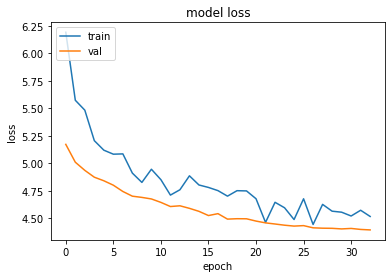

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
acc = [0.3650,
0.3688,
0.3715,
0.3715,
0.3765,
0.3751,
0.3772,
0.3787,
0.3801,
0.3778,
0.3788,
0.3805,
0.3795 ,
0.3805,
0.3805,
0.3802,
0.3799,
0.3801,
0.3820,
0.3820,
0.3820,
0.3832,
0.3852,
0.3834,
0.3837,
0.3844,
0.3860,
0.3860,
0.3867,
0.3857,
0.3850,
0.3869,
0.3850]

In [ ]:
val_acc = [0.3683,
0.3624,
0.3524,
0.3521,
0.3513,
0.3526,
0.3519,
0.3484,
0.3545,
0.3524,
0.3506,
0.3546,
0.3520,
0.3564,
0.3538,
0.3588,
0.3616,
0.3638,
0.3613,
0.3621,
0.3628,
0.3629,
0.3615,
0.3615,
0.3610,
0.3670,
0.3673,
0.3678,
0.3691,
0.3699,
0.3699,
0.3713,
0.3724]

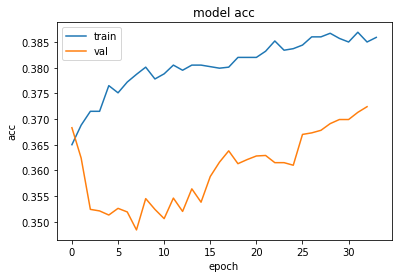

In [ ]:
plt.plot(acc)
plt.plot(val_acc)
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
%cd Merge_COCO_FILES

/content/drive/MyDrive/Colab Notebooks/pelee_keras/experiments/Merge_COCO_FILES


In [ ]:
!python merge.py n5.json out.json out.json

 96% 5740/6000 [00:17<00:00, 330.97it/s]
 96% 5740/6000 [00:25<00:01, 224.41it/s]


Thanks for using our service :p !!


In [ ]:
 !python merge.py n6.json out.json out.json

 96% 6696/7000 [00:26<00:01, 250.36it/s]
 96% 6696/7000 [00:35<00:01, 186.35it/s]


Thanks for using our service :p !!


In [ ]:
!python merge.py n7.json out.json out.json

 96% 7645/8000 [00:36<00:01, 210.91it/s]
 96% 7645/8000 [00:51<00:02, 149.34it/s]


Thanks for using our service :p !!


In [ ]:
!python merge.py n9.json out.json out.json

 96% 9560/10000 [00:56<00:02, 170.19it/s]
 96% 9560/10000 [01:09<00:03, 136.85it/s]


Thanks for using our service :p !!


In [ ]:
\